In [1]:
%matplotlib inline 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
vgg = list(torchvision.models.vgg19_bn(pretrained=True).features[:-1].children())
vgg = nn.Sequential(*[nn.AvgPool2d(2) if isinstance(n, nn.MaxPool2d) else n for n in vgg]).to(dev)
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [4]:
# All conv layers. Replace maxpool with average as proposed in paper?
conv_ids = [int(idx) for idx, m in vgg.named_children() if isinstance(m, nn.Conv2d)]
len(conv_ids)

16

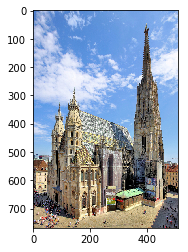

In [5]:
p = np.array(Image.open('stephansdom_small.png'))
plt.imshow(p)
plt.show()

In [6]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

tnorm = transforms.Compose([
    transforms.ToTensor(), # 0..1
    transforms.Normalize(mean=mean, std=std)    
])

class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
class Clip:
    def __call__(self, tensor):
        return torch.clamp(tensor, min=0., max=1.)
    
class ToNumpy():
    def __call__(self, tensor):
        t = np.transpose(tensor.detach().numpy(), (1, 2, 0))
        t *= 255.
        return t.astype(np.uint8)
        
tdenorm = transforms.Compose([
    Denormalize(mean=mean, std=std),
    Clip(),
    ToNumpy()    
])

In [7]:
def select_layer_up_to(net, layer_id):
    return net[:(layer_id+2)] # +2 BN, relu

In [8]:
def content_representation(net, x):
    return net(x)

In [28]:
from tqdm import tqdm

def norm(x, alpha=2):       
    return (x**alpha).sum()

def tv_norm(x, beta):
    tl = x[..., :-1, :-1]
    tr = x[..., :-1,  1:]
    bl = x[..., 1:,  :-1]
    
    tv = ((tl - tr)**2 + (tl - bl)**2)**(beta*0.5)
    return tv.sum()
        
def reconstruct_image(net, dev, repfn, image, niter=700, lr=1e4, lam_alpha=1e-7, lam_t=1e-8):
    
    image = image.to(dev).unsqueeze(0)
    x = torch.tensor(torch.randn_like(image)*1e-1, requires_grad=True).to(dev)
    
    opt = optim.SGD([x], lr=lr, momentum=0.9)
    scheduler = sched.StepLR(opt, step_size=niter//3, gamma=0.5, last_epoch=-1)
    
    rep_target = repfn(net, image)
    
    alpha = 6.
    beta = 2.
    
    with tqdm(total=niter) as t: 
        for _ in range(niter):
            opt.zero_grad()
            
            rep_x = repfn(net, x)
            
            eloss = norm(rep_x - rep_target, 2) / norm(rep_target)
            aloss = norm(x, alpha)
            tloss = tv_norm(x, beta)
            loss = eloss #+ lam_alpha * aloss + lam_t * tloss
            loss.backward()
            
            opt.step()
            scheduler.step()
            
            t.set_postfix(loss=loss.item(), grad=torch.abs(x.grad).max().item())
            t.update()            
    
    return x

100%|█████████████████████████████████████████████████████| 300/300 [00:21<00:00, 14.00it/s, grad=7.36e-07, loss=0.012]


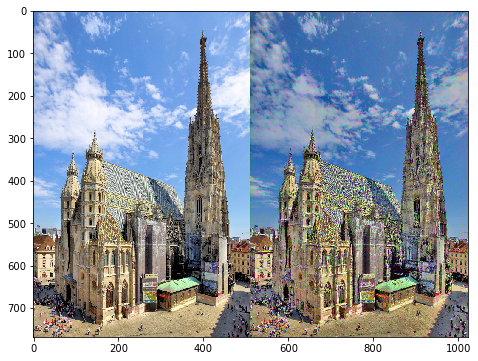

In [30]:
net = select_layer_up_to(vgg, conv_ids[4])
x = reconstruct_image(net, dev, content_representation, tnorm(p), niter=300)
xx = tdenorm(x.squeeze().cpu())

plt.figure(figsize=(12,6))
plt.imshow(np.hstack((p, xx)))
plt.show()